In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'pytorch'

In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/userhome/jeon_mg/miniforge3/envs/pinn_torch/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [3]:
spatial_norm = 256
b_norm = 2500

In [4]:
geom = dde.geometry.Cuboid(xmin=[0, 0, 0], xmax=[2, 1, 1])

In [5]:
coords = np.load('coords.npy')
values = np.load('values.npy')

pf_coords = np.load('pf_coords.npy')
pf_values = np.load('pf_values.npy')

In [6]:
coords.shape, values.shape, pf_coords.shape, pf_values.shape

((131841, 3), (131841, 3), (32768, 3), (32768, 3))

In [7]:
bc_bottom_Bx = dde.icbc.PointSetBC(coords/spatial_norm, values[:, 0].reshape(-1, 1)/b_norm, component=0, batch_size=5000)
bc_bottom_By = dde.icbc.PointSetBC(coords/spatial_norm, values[:, 1].reshape(-1, 1)/b_norm, component=1, batch_size=5000)
bc_bottom_Bz = dde.icbc.PointSetBC(coords/spatial_norm, values[:, 2].reshape(-1, 1)/b_norm, component=2, batch_size=5000)

In [8]:
def pde(X, Y):
    eps = 1e-7
    
    Bx = Y[:, 0:1]
    By = Y[:, 1:2]
    Bz = Y[:, 2:3]

    norm_B = (Bx**2) + (By**2) + (Bz**2)
    
    dBx_x = dde.grad.jacobian(Y, X, i=0, j=0)
    dBx_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dBx_z = dde.grad.jacobian(Y, X, i=0, j=2)

    dBy_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dBy_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dBy_z = dde.grad.jacobian(Y, X, i=1, j=2)

    dBz_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dBz_y = dde.grad.jacobian(Y, X, i=2, j=1)
    dBz_z = dde.grad.jacobian(Y, X, i=2, j=2)

    Jx = dBz_y - dBy_z
    Jy = dBx_z - dBz_x
    Jz = dBy_x - dBx_y

    JxB_x = Jy*Bz - Jz*By
    JxB_y = Jz*Bx - Jx*Bz
    JxB_z = Jx*By - Jy*Bx
    
    norm_JxB = (JxB_x**2) + (JxB_y**2) + (JxB_z**2)

    loss_JxB = norm_JxB / (norm_B + eps)

    divB = dBx_x + dBy_y + dBz_z

    loss_divB = (divB**2)

    return [loss_JxB, loss_divB]

In [9]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_bottom_Bx, bc_bottom_By, bc_bottom_Bz],
                    num_domain=20000,
                    num_boundary=10000,
                    num_test=10000)

Text(0, 0.5, 'y')

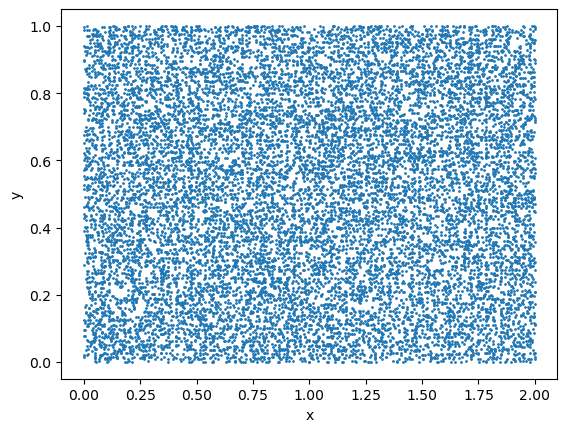

In [10]:
plt.scatter(data.train_x_bc[:, 0], data.train_x_bc[:, 1], s=1)
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

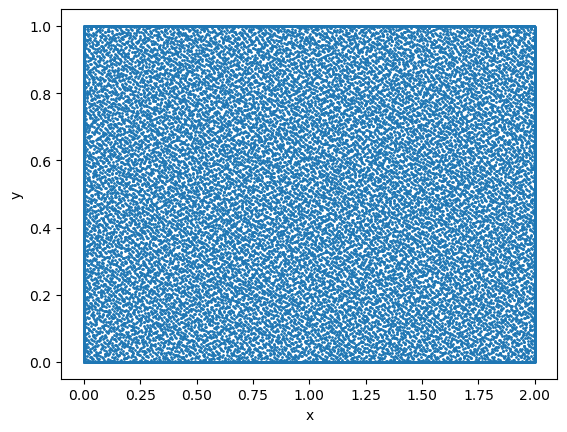

In [11]:
plt.scatter(data.train_x_all[:, 0], data.train_x_all[:, 1], s=1)
plt.xlabel('x')
plt.ylabel('y')

In [12]:
layer_size = [3] + [256] * 8 + [3]
activation = 'sin'
initializer = 'Glorot normal'

net = dde.nn.FNN(layer_size, activation, initializer)

In [13]:
model = dde.Model(data, net)

In [ ]:
lr_start = 5e-4
lr_end = 5e-5
decay_iterations = 100000
gamma=(lr_end / lr_start) ** (1 / decay_iterations)

In [14]:
model.compile('adam', lr=5e-4, loss_weights=[1, 1, 1000, 1000, 1000], decay=("exponential", gamma))

Compiling model...
'compile' took 0.263725 s



In [15]:
pde_resampler = dde.callbacks.PDEPointResampler(bc_points=True)

In [ ]:
checkpointer = dde.callbacks.ModelCheckpoint(
    "models/nf2", verbose=1, save_better_only=True 
)

In [16]:
loss_history, train_state = model.train(iterations=100000, callbacks=[pde_resampler, checkpointer])

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [4.79e-03, 3.47e-03, 1.69e+01, 1.96e+01, 3.07e+01]    [5.00e-03, 3.52e-03, 1.69e+01, 1.96e+01, 3.07e+01]    []  
1000      [9.84e-05, 2.10e-06, 8.50e+00, 1.04e+01, 2.09e+01]    [4.58e-05, 1.62e-06, 8.73e+00, 1.08e+01, 2.14e+01]    []  
2000      [7.89e-06, 8.59e-06, 8.09e+00, 1.06e+01, 2.12e+01]    [5.07e-06, 8.64e-06, 8.25e+00, 1.09e+01, 2.17e+01]    []  
3000      [5.04e-02, 1.25e-02, 7.60e+00, 7.83e+00, 1.94e+01]    [2.79e-02, 1.06e-02, 1.02e+01, 1.24e+01, 2.70e+01]    []  
4000      [3.13e-01, 7.70e-02, 3.66e+00, 3.43e+00, 8.23e+00]    [6.48e-02, 4.60e-02, 1.30e+01, 1.57e+01, 3.49e+01]    []  
5000      [2.93e-01, 6.08e-02, 5.44e+00, 5.78e+00, 1.45e+01]    [2.04e-01, 5.01e-02, 1.25e+01, 1.45e+01, 2.88e+01]    []  
6000      [4.20e-01, 1.34e-01, 4.49e+00, 3.72e+00, 7.97e+00]    [1.59e-01, 5.68e-02, 1.32e+01, 1.48e+01, 3.26e+01

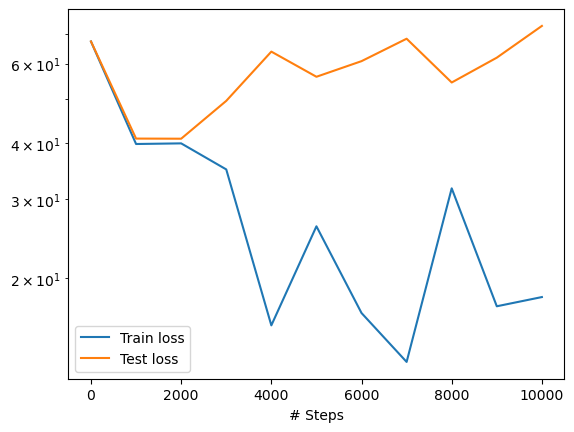

In [17]:
dde.saveplot(loss_history, train_state, issave=False, isplot=True)

In [21]:
B = model.predict(coords/spatial_norm)*b_norm

In [22]:
b_slices = B.reshape(513, 257, 1, 3)

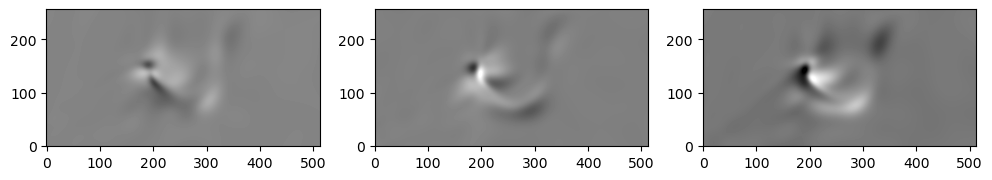

In [23]:
for i in range(b_slices.shape[2]):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(b_slices[..., i, 0].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    axs[1].imshow(b_slices[..., i, 1].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    axs[2].imshow(b_slices[..., i, 2].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    plt.show()